In [5]:
import numpy as np
import scipy as sp  
import sys, json, os
from scipy.special import erf
from scipy.interpolate import interp1d
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
sys.path.append('../../')
from project.recoil import Electron as El
from project.recoil import p50, get_vdf_ert

In [11]:
MWdict = pickle.load(open('../../Output/MW_dict.pkl','rb'))
MWlike = pickle.load(open('../../Output/MWlike_dict.pkl','rb'))
mwld = MWlike['vdf_RCfit']
mwd = mwld['MW']
mwp = MWdict['vdf_PBRCfit']
mwgals = MWlike['mwgals']

In [3]:
vgal = np.linspace(1e-5,1e3,1000)
fshm = np.exp(-(vgal/220)**2)
fshm[vgal>544.] = 0
fgal = vgal**2 * fshm
fgal = fgal/np.trapz(fgal,vgal)
vE= np.linspace(1e-5,1000,1000)
fE = get_vdf_ert(vE, vgal, fgal, 544., 220.)

In [5]:
el = El('Si', vE, fE, 544., 220., 0.4)
Ee = np.linspace(0,49,50)
rate = el.dRdEe(10, 1e-37, Ee)

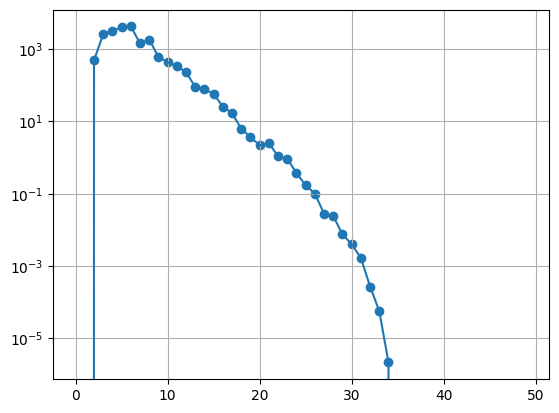

In [7]:
plt.scatter(Ee, rate)
plt.plot(Ee, rate)
plt.yscale('log')
plt.grid()

In [ ]:
mwd.keys()
mwp = MWlike['vdf']

dict_keys(['v', 'vdfs', 'vdf_16', 'vdf_50', 'vdf_84', 'vdfE_16', 'vdfE_50', 'vdfE_84', 'vE', 'vdfEs', 'vescs', 'vcircs', 'vescRs', 'rhosuns', 'full_pdfs', 'full_samp', 'full_indxs', 'full_sampN', 'par_pdfs', 'par_samp', 'par_indxs', 'par_sampN'])

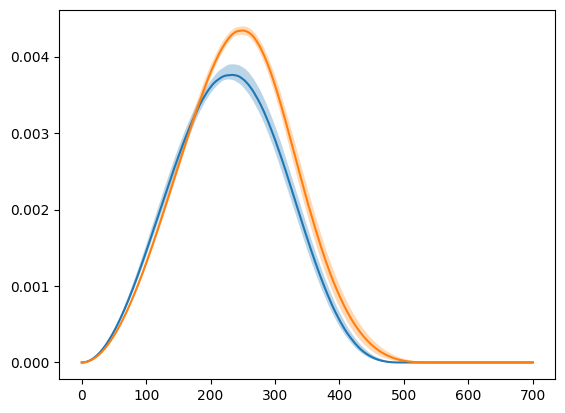

In [12]:
plt.plot(mwd['v'], mwd['vdf_50'])
plt.fill_between(mwd['v'], mwd['vdf_16'], mwd['vdf_84'], alpha=0.3)
plt.plot(mwp['v'], mwp['vdf_50'])
plt.fill_between(mwp['v'], mwp['vdf_16'], mwp['vdf_84'], alpha=0.3)